In [1]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np
import sklearn
import pandas as pd
import tensorflow as tf

import os
import sys
import time

from tensorflow import keras
from tensorflow.keras.models import Sequential
from numpy import array

for module in [matplotlib, np, sklearn, pd, tf]:
    print(module.__name__, module.__version__)

matplotlib 3.2.0
numpy 1.18.1
sklearn 0.22.2.post1
pandas 0.24.1
tensorflow 2.0.0


In [2]:
fashion_mnist = keras.datasets.fashion_mnist
(x_train_all, y_train_all), (x_test, y_test) = fashion_mnist.load_data()

# 数据集中共有6w个样本 用前5000个样本作为验证集, 后5.5w个样本作为训练集
x_valid, x_train = x_train_all[: 5000], x_train_all[5000: ]
y_valid, y_train = y_train_all[: 5000], y_train_all[5000: ]

print(x_valid.shape, y_valid.shape)
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(5000, 28, 28) (5000,)
(55000, 28, 28) (55000,)
(10000, 28, 28) (10000,)


In [3]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

# x_train: [None, 28, 28] -> [None, 784]
x_train_scaled = scaler.fit_transform(x_train.astype(np.float32).reshape([-1, 1])).reshape(-1, 28, 28)
x_valid_scaled = scaler.transform(x_valid.astype(np.float32).reshape([-1, 1])).reshape(-1, 28, 28)
x_test_scaled = scaler.transform(x_test.astype(np.float32).reshape([-1, 1])).reshape(-1, 28, 28)

In [5]:
model: Sequential = keras.models.Sequential()

model.add(keras.layers.Flatten(input_shape=[28, 28]))
for _ in range(20):
    # 先使用激活函数, 再进行归一化
    model.add(keras.layers.Dense(100, activation="relu"))
    # 增加一个批归一化的层次
    model.add(keras.layers.BatchNormalization())
    
    
    """
    先进行批归一化, 再使用激活函数
    model.add(keras.layers.Dense(100))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.Activation("relu"))
    """
    
model.add(keras.layers.Dense(10, activation="softmax"))
    
# relu: y = max(0, x)
# softmax: 将向量变成概率分布 x = [x1, x2, x3]
#       y = [[e^x1/sum, e^x2/sum, e^x3/sum], sum=e^x1+e^x2+e^x3]

# reason for sparse: y->index, y->onehot->[]
model.compile(
    loss="sparse_categorical_crossentropy", 
    optimizer="adam",
    metrics=["accuracy"]
)



In [6]:
# Tensorboard, EarlyStopping, ModelCheckPoint
logdir = "./callbacks_dnn"
if not os.path.exists(logdir):
    os.mkdir(logdir)
output_model_file = os.path.join(logdir, "fashion_mnist_model.h5")


callbacks: list = [
    keras.callbacks.TensorBoard(logdir),
    keras.callbacks.ModelCheckpoint(output_model_file, save_best_only=True),
    keras.callbacks.EarlyStopping(patience=5, min_delta=1e-3)
]


history = model.fit(
    x_train_scaled, 
    y_train, epochs=10, 
    validation_data=(x_valid_scaled, y_valid),
    callbacks=callbacks
)

Train on 55000 samples, validate on 5000 samples
Epoch 1/10
55000/55000 [==============================] - 12s 219us/sample - loss: 0.7644 - accuracy: 0.7051 - val_loss: 0.5037 - val_accuracy: 0.8298
Epoch 2/10
55000/55000 [==============================] - 11s 204us/sample - loss: 0.5554 - accuracy: 0.8133 - val_loss: 0.5011 - val_accuracy: 0.8314
Epoch 3/10
55000/55000 [==============================] - 10s 187us/sample - loss: 0.5261 - accuracy: 0.8236 - val_loss: 0.4450 - val_accuracy: 0.8542
Epoch 4/10
55000/55000 [==============================] - 10s 184us/sample - loss: 0.4897 - accuracy: 0.8330 - val_loss: 0.5196 - val_accuracy: 0.8142
Epoch 5/10
55000/55000 [==============================] - 10s 182us/sample - loss: 0.4819 - accuracy: 0.8339 - val_loss: 0.4379 - val_accuracy: 0.8606
Epoch 6/10
55000/55000 [==============================] - 10s 180us/sample - loss: 0.4940 - accuracy: 0.8324 - val_loss: 0.4845 - val_accuracy: 0.8316
Epoch 7/10
55000/55000 [=====================

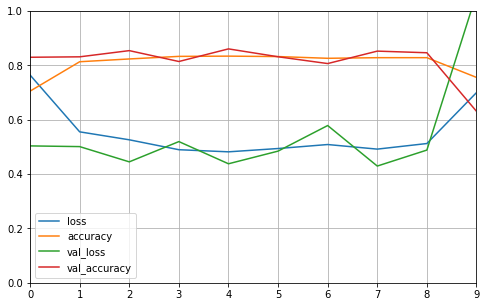

In [7]:
def plot_learning_curve(history):
    pd.DataFrame(history.history).plot(figsize=(8, 5))
    plt.grid(True)
    plt.gca().set_ylim(0, 1)
    plt.show()
    
plot_learning_curve(history)

In [8]:
result = model.evaluate(x_test, y_test)

10000/1 [===============================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================